#### Solver

divergence : KL, solver : sinkhorn

`P` : $\textbf{P}$

`G`: $\textbf{G}$

`c_p` : $c_P$

`c_g` : $c_G$

`w_s` : $w_S$

`w_t` : $w_T$

`rho` : $\rho$

`eps`: $\epsilon$

`alpha`: $\alpha$



In [1]:
from fugw.utils import _init_mock_distribution
import torch
import numpy as np
from simple_fugw.solver import FUGW

torch.manual_seed(0)

n_points_source = 50
n_points_target = 40
n_features_train = 2
n_features_test = 2

# %%
# Let us generate random training data for the source and target distributions
_, source_features_train, source_geometry, source_embeddings = (
    _init_mock_distribution(n_features_train, n_points_source)
)
_, target_features_train, target_geometry, target_embeddings = (
    _init_mock_distribution(n_features_train, n_points_target)
)

source_features_train_normalized = source_features_train / torch.linalg.norm(
    source_features_train, dim=1
).reshape(-1, 1)
target_features_train_normalized = target_features_train / torch.linalg.norm(
    target_features_train, dim=1
).reshape(-1, 1)

source_geometry_normalized = source_geometry / source_geometry.max()
target_geometry_normalized = target_geometry / target_geometry.max()

alpha = 0.5
rho = 1000
eps = 1e-4
mapping = FUGW(alpha=alpha, rho=rho, eps=eps)


_ = mapping.fit(
    source_features=source_features_train_normalized,
    target_features=target_features_train_normalized,
    source_geometry=source_geometry_normalized,
    target_geometry=target_geometry_normalized,
)

/Users/juliengenzling/anaconda3/envs/kaggle/lib/python3.11/site-packages/torch/distributions/wishart.py:253: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


init ws : tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200,
        0.0200, 0.0200, 0.0200, 0.0200, 0.0200])
init wt : tensor([0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250, 0.0250,
        0.0250, 0.0250, 0.0250, 0.0250])
init ws_wt : tensor([[0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
        [0.0005, 0.0005, 0.0005,  ..., 0.0005, 0.0005, 0.0005],
        [0.0005, 0.0005, 0.00

In [2]:
P = _["P"]

In [3]:
print(f"Transport plan's total mass: {P.sum():.5f}")

Transport plan's total mass: 0.99999


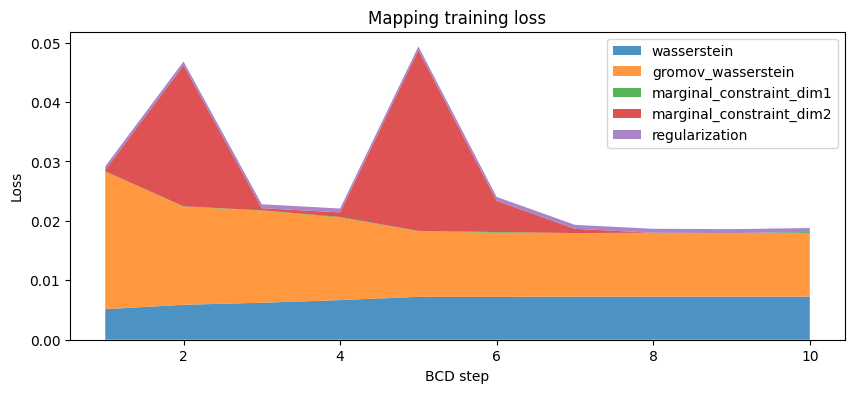

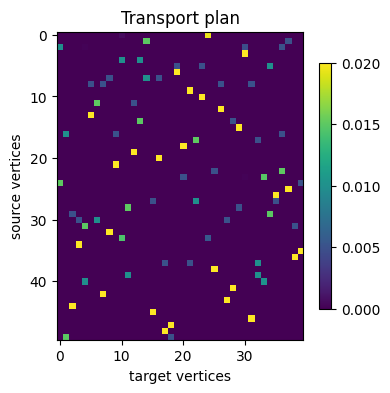

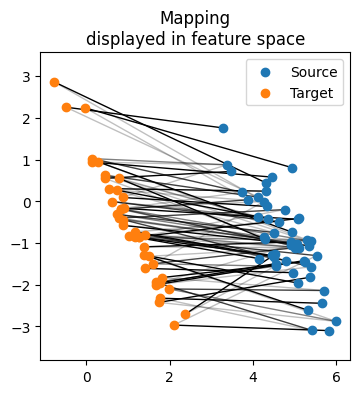

TypeError: FUGW.transform() takes 0 positional arguments but 2 were given

In [4]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# %%
# The transport plan can be accessed after the model has been fitted
# %%
# Here is the evolution of the FUGW loss during training,
# as well as the contribution of each loss term:

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Mapping training loss")
ax.set_ylabel("Loss")
ax.set_xlabel("BCD step")
ax.stackplot(
    mapping.loss_steps,
    [
        (1 - alpha) * np.array(mapping.loss["wasserstein"]),
        alpha * np.array(mapping.loss["gromov_wasserstein"]),
        rho * np.array(mapping.loss["marginal_constraint_dim1"]),
        rho * np.array(mapping.loss["marginal_constraint_dim2"]),
        eps * np.array(mapping.loss["regularization"]),
    ],
    labels=[
        "wasserstein",
        "gromov_wasserstein",
        "marginal_constraint_dim1",
        "marginal_constraint_dim2",
        "regularization",
    ],
    alpha=0.8,
)
ax.legend()
plt.show()

# %%
# Using the computed mapping
# --------------------------
# The computed mapping is stored in ``mapping.pi`` as a ``torch.Tensor``.
# In this example, the transport plan is small enough that we can display
# it altogether.

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title("Transport plan")
ax.set_xlabel("target vertices")
ax.set_ylabel("source vertices")
im = plt.imshow(P, cmap="viridis")
plt.colorbar(im, ax=ax, shrink=0.8)
plt.show()

# %%
# The previous figure of the transport plan tells us it is very sparse
# and not very regularized.
# Another informative way to look at the plan consists in checking
# which points of the source and target distributions
# were matched together in the feature space.

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.set_aspect("equal", "datalim")
ax.set_title("Mapping\ndisplayed in feature space")

# Draw lines between matched points
indices = torch.cartesian_prod(
    torch.arange(n_points_source), torch.arange(n_points_target)
)
segments = torch.stack(
    [
        source_features_train[:, indices[:, 0]],
        target_features_train[:, indices[:, 1]],
    ]
).permute(2, 0, 1)
pi_normalized = P / P.sum(dim=1).reshape(-1, 1)
line_segments = LineCollection(
    segments, alpha=pi_normalized.flatten(), colors="black", lw=1, zorder=1
)
ax.add_collection(line_segments)

# Draw distributions
ax.scatter(source_features_train[0], source_features_train[1], label="Source")
ax.scatter(target_features_train[0], target_features_train[1], label="Target")

ax.legend()
plt.show()

# %%
# Finally, the fitted model can transport unseen data
# between source and target
source_features_test = torch.rand(n_features_test, n_points_source)
target_features_test = torch.rand(n_features_test, n_points_target)
transformed_data = mapping.transform(source_features_test)
transformed_data.shape

# %%
assert transformed_data.shape == target_features_test.shape

# %%


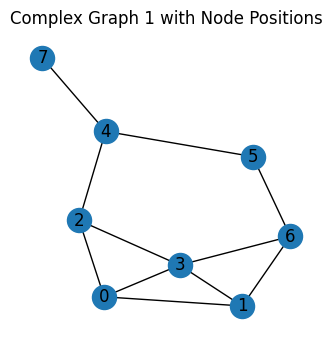

In [66]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

source_adjacency_matrix = np.array([[0, 1, 1, 1, 0, 0, 0, 0],
                             [1, 0, 0, 1, 0, 0, 1, 0],
                             [1, 0, 0, 1, 1, 0, 0, 0],
                             [1, 1, 1, 0, 0, 0, 1, 0],
                             [0, 0, 1, 0, 0, 1, 0, 1],
                             [0, 0, 0, 0, 1, 0, 1, 0],
                             [0, 1, 0, 1, 0, 1, 0, 0],
                             [0, 0, 0, 0, 1, 0, 0, 0]])

n_points_source = len(source_adjacency_matrix)

source_graph = nx.Graph(source_adjacency_matrix)

source_locations = nx.spring_layout(source_graph)

source_features = np.ones(n_points_source)

plt.figure(figsize=(3, 3))
nx.draw(source_graph, source_locations, with_labels=True)
plt.title('Complex Graph 1 with Node Positions')
plt.show()

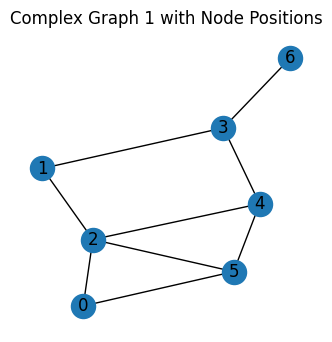

In [67]:
target_adjacency_matrix = np.array([
                             [0, 0, 1, 0, 0, 1, 0],
                             [0, 0, 1, 1, 0, 0, 0],
                             [1, 1, 0, 0, 1, 1, 0],
                             [0, 1, 0, 0, 1, 0, 1],
                             [0, 0, 1, 1, 0, 1, 0],
                             [1, 0, 1, 0, 1, 0, 0],
                             [0, 0, 0, 1, 0, 0, 0]])

n_points_target = len(target_adjacency_matrix)

target_graph = nx.Graph(target_adjacency_matrix)

target_locations = nx.spring_layout(target_graph)

target_features = np.ones(n_points_target)

plt.figure(figsize=(3, 3))
nx.draw(target_graph, target_locations, with_labels=True)
plt.title('Complex Graph 1 with Node Positions')
plt.show()

In [ ]:
import torch
import numpy as np
from simple_fugw.solver import FUGW

torch.manual_seed(0)


source_geometry = torch.tensor(source_adjacency_matrix, dtype=torch.float32).T
target_geometry = torch.tensor(target_adjacency_matrix, dtype=torch.float32)

source_features = torch.ones(1,n_points_source)

target_features = torch.ones(1,n_points_target)

source_features_train_normalized = source_features / torch.linalg.norm(
    source_features, dim=1
).reshape(-1, 1)
target_features_train_normalized = target_features / torch.linalg.norm(
    target_features, dim=1
).reshape(-1, 1)


source_geometry_normalized = source_geometry / source_geometry.max()
target_geometry_normalized = target_geometry / target_geometry.max()

alpha = 0.5
rho = 1000
eps = 1e-4
mapping = FUGW(alpha=alpha, rho=rho, eps=eps)


result = mapping.fit(
    source_features=source_features_train_normalized,
    target_features=target_features_train_normalized,
    source_geometry=source_geometry_normalized,
    target_geometry=target_geometry_normalized,
)

P = result["P"]

fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Mapping training loss")
ax.set_ylabel("Loss")
ax.set_xlabel("BCD step")
ax.stackplot(
    mapping.loss_steps,
    [
        (1 - alpha) * np.array(mapping.loss["wasserstein"]),
        alpha * np.array(mapping.loss["gromov_wasserstein"]),
        rho * np.array(mapping.loss["marginal_constraint_dim1"]),
        rho * np.array(mapping.loss["marginal_constraint_dim2"]),
        eps * np.array(mapping.loss["regularization"]),
    ],
    labels=[
        "wasserstein",
        "gromov_wasserstein",
        "marginal_constraint_dim1",
        "marginal_constraint_dim2",
        "regularization",
    ],
    alpha=0.8,
)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title("Transport plan")
ax.set_xlabel("target vertices")
ax.set_ylabel("source vertices")
im = plt.imshow(P, cmap="viridis")
plt.colorbar(im, ax=ax, shrink=0.8)
plt.show()

In [70]:
print(source_locations)

{0: array([-0.19612857, -0.58351175]), 1: array([ 0.27162944, -0.64419798]), 2: array([-0.28083707, -0.0765101 ]), 3: array([ 0.05956422, -0.37321933]), 4: array([-0.19126257,  0.51367445]), 5: array([0.30756135, 0.34624699]), 6: array([ 0.4347849 , -0.18248228]), 7: array([-0.40531171,  1.        ])}


In [61]:
print(target_geometry.shape)

torch.Size([7, 7])


In [71]:
print(P)

tensor([[3.2367e-02, 5.0939e-02, 2.0829e-02, 2.1760e-19, 0.0000e+00, 2.0844e-02,
         0.0000e+00],
        [1.1346e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1536e-02, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2500e-01, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.2500e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2500e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 9.4891e-02, 0.0000e+00, 0.0000e+00, 9.2767e-03, 0.0000e+00,
         2.0828e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2499e-01,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.2500e-01]])


In [80]:
source_loc = []
for value in source_locations.values():
    source_loc.append(value)

In [81]:
target_loc = []
for value in target_locations.values():
    target_loc.append(value)

In [96]:
def plot_graph_matching(source_adjacency_matrix, target_adjacency_matrix, source_geometry, target_geometry, P, distance_between_graphs):
    """
    """
    print(target_geometry)
    target_geometry[:,1] += distance_between_graphs
    print(target_geometry)
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax = fig.add_subplot()
    ax.set_aspect("equal", "datalim")
    ax.set_title("Graph mapping")

    ###Add the nodes in the graph

    ax.scatter(source_geometry[0], source_geometry[1], label="Source")
    ax.scatter(target_geometry[0], target_geometry[1], label="Target")

    ###Add segments of transports
    segments = torch.stack(
    [
        source_geometry[:, indices[:, 0]],
        target_geometry[:, indices[:, 1]],
    ]
    ).permute(2, 0, 1)
    pi_normalized = P / P.sum(dim=1).reshape(-1, 1)
    line_segments = LineCollection(
        segments, alpha=pi_normalized.flatten(), colors="black", lw=1, zorder=1
    )
    ax.add_collection(line_segments)

    ###Add edges in the graph

    segments = torch.stack(
    [
        source_adjacency_matrix[:, indices[:, 0]],
        target_adjacency_matrix[:, indices[:, 1]],
    ]
    ).permute(2, 0, 1)
    line_segments = LineCollection(
        segments, colors="black", lw=1, zorder=1
    )
    ax.add_collection(line_segments)

    ax.legend()
    plt.show() 

[[-0.18904699 -0.79103585]
 [-0.27305181  0.2026376 ]
 [-0.16925156 -0.3109496 ]
 [ 0.09949968  0.49546074]
 [ 0.17408233 -0.05317168]
 [ 0.12048265 -0.5429412 ]
 [ 0.2372857   1.        ]]
[[-0.18904699 -0.29103585]
 [-0.27305181  0.7026376 ]
 [-0.16925156  0.1890504 ]
 [ 0.09949968  0.99546074]
 [ 0.17408233  0.44682832]
 [ 0.12048265 -0.0429412 ]
 [ 0.2372857   1.5       ]]


IndexError: index 2 is out of bounds for axis 1 with size 2

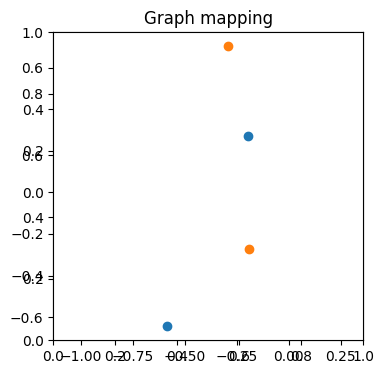

In [97]:
plot_graph_matching(source_adjacency_matrix, target_adjacency_matrix, np.array(source_loc), np.array(target_loc), P, 0.5)